Looking to plot linear, poly, and local weighted regression line on scatter

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm

In [2]:
data = pd.read_csv('abalone.data',header=None, nrows = 1000)
data.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
data.sort_values(by='length', inplace=True)
data

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
236,I,0.075,0.055,0.010,0.0020,0.0010,0.0005,0.0015,1
238,I,0.110,0.090,0.030,0.0080,0.0025,0.0020,0.0030,3
237,I,0.130,0.100,0.030,0.0130,0.0045,0.0030,0.0040,3
719,I,0.150,0.100,0.025,0.0150,0.0045,0.0040,0.0050,2
696,I,0.155,0.105,0.050,0.0175,0.0050,0.0035,0.0050,4
...,...,...,...,...,...,...,...,...,...
165,M,0.725,0.570,0.190,2.5500,1.0705,0.4830,0.7250,14
891,M,0.730,0.595,0.230,2.8255,1.1465,0.4190,0.8970,17
478,M,0.735,0.590,0.225,1.7560,0.6370,0.3405,0.5800,21
334,F,0.740,0.600,0.195,1.9740,0.5980,0.4085,0.7100,16


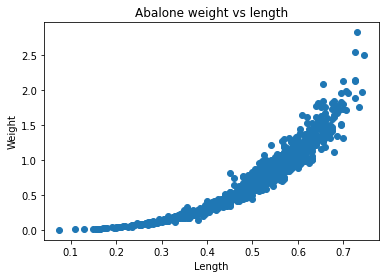

In [3]:
_X = np.array(data['length'])
_y = np.array(data['whole_weight'])
plt.scatter(_X, _y)
plt.title('Abalone weight vs length')
plt.xlabel('Length')
plt.ylabel('Weight');

---

In [4]:
# adding feature intercept
_X_with_intercept = np.array([np.power(_X, p) for p in range(2)]).T

In [5]:
_X_with_intercept

array([[1.   , 0.075],
       [1.   , 0.11 ],
       [1.   , 0.13 ],
       ...,
       [1.   , 0.735],
       [1.   , 0.74 ],
       [1.   , 0.745]])

In [6]:
_X_with_intercept.shape

(1000, 2)

In [7]:
_X_with_intercept.T.shape

(2, 1000)

In [8]:
_X_with_intercept.T

array([[1.   , 1.   , 1.   , ..., 1.   , 1.   , 1.   ],
       [0.075, 0.11 , 0.13 , ..., 0.735, 0.74 , 0.745]])

In [9]:
_Xt_X_inv = np.linalg.pinv(_X_with_intercept.T @ _X_with_intercept)
_Xt_y = _X_with_intercept.T @ _y
_beta = _Xt_X_inv @ _Xt_y
_beta

array([-0.99446296,  3.48551089])

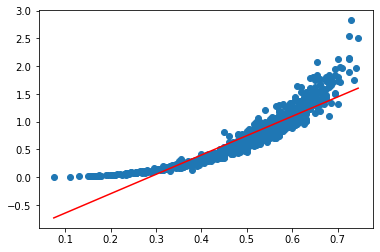

In [10]:
y_hat = _beta @ _X_with_intercept.T
plt.plot(_X, y_hat, color = 'r')
plt.scatter(_X, _y);

---

In [11]:
# adding polynomial feature with intercept
def polynomial_degree(x, degree= 1):
    """
    returns polynomial features for one variable
    """
    
    array = np.array([np.power(x, p) for p in range(degree + 1)])
    
    return array.T

In [12]:
_X_poly = polynomial_degree(_X, 2)

In [13]:
_Xt_X_inv = np.linalg.pinv(_X_poly.T @ _X_poly)
_Xt_y = _X_poly.T @ _y
_beta = _Xt_X_inv @ _Xt_y
_beta

array([ 0.38285528, -3.07171752,  7.2131967 ])

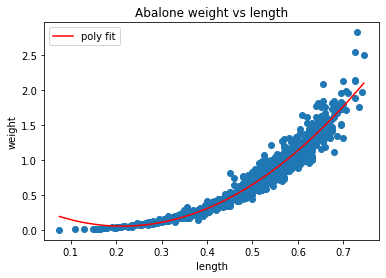

In [15]:
y_hat = _beta @ _X_poly.T
plt.plot(_X, y_hat, color = 'r', label = 'poly fit')
plt.scatter(_X, _y)
plt.legend(loc='upper left')
plt.title('Abalone weight vs length')
plt.xlabel('length')
plt.ylabel('weight');

---

In [16]:
# weighted polynomial regression
_X_mat = np.mat(_X_poly)
_y_mat = np.mat(_y)

In [17]:
weights = np.mat(np.eye((len(_X_mat))))

In [18]:
for j in range(1000):
    # calculate difference off first entry
    diff = _X_mat[0] - _X_mat[j]
    weights[j, j] = np.exp(np.power(diff @ diff.T,2) / (-2 * 0.05**2))
    
W = np.linalg.pinv(_X_mat.T @ (weights @ _X_mat)) @ (_X_mat.T @ weights @ _y_mat.T)
y_hat = np.asarray(_X_mat @ W).reshape(-1)

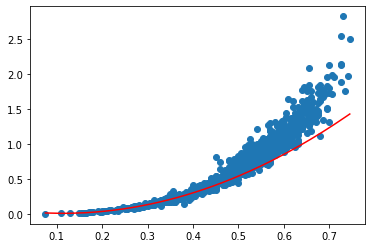

In [19]:
plt.plot(_X, y_hat, color = 'r')
plt.scatter(_X, _y)

---

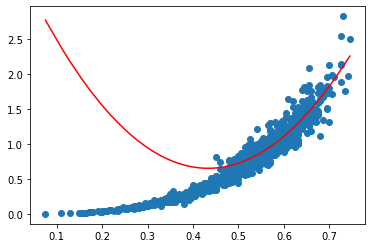

In [20]:
for j in range(1000):
    # calculate difference off last entry
    diff = _X_mat[-1] - _X_mat[j]
    weights[j, j] = np.exp(np.power(diff @ diff.T,2) / (-2 * 0.05**2))
    
W = np.linalg.pinv(_X_mat.T @ (weights @ _X_mat)) @ (_X_mat.T @ weights @ _y_mat.T)
y_hat = np.asarray(_X_mat @ W).reshape(-1)
plt.plot(_X, y_hat, color = 'r')
plt.scatter(_X, _y);

---

## Hello

In [21]:
def kernel(point, xmat, k):
    m, n = np.shape(xmat)
    weights = np.mat(np.eye((m)))
    
    for j in range(m):
        diff = point - _X_mat[j]
        weights[j, j] = np.exp(np.power(diff @ diff.T,1) / (-2.0 * k**2))
        
    return weights


def localWeight(point, xmat, ymat, k):
    weight = kernel(point, xmat, k)
    
    W = np.linalg.inv(_X_mat.T @ (weight @ _X_mat)) @ (_X_mat.T @ weight @ ymat.T)
    return W


def localWeightRegression(xmat, ymat, k):
    m,n = np.shape(xmat)
    y_hat = np.zeros(m)
    
    for i in tqdm(range(m)):
        y_hat[i] = xmat[i] * localWeight(xmat[i], xmat, ymat, k)
        
    
        
    return y_hat
    
    
    

y_hat = localWeightRegression(_X_mat, _y_mat, 0.02)

100%|██████████| 1000/1000 [00:47<00:00, 21.17it/s]


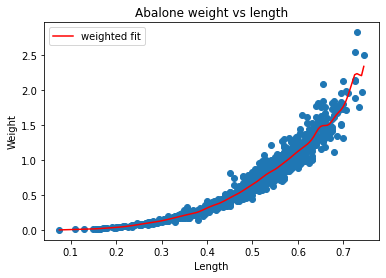

In [22]:
plt.plot(_X, y_hat, color = 'r', label = 'weighted fit')
plt.scatter(_X, _y)
plt.xlabel('Length')
plt.ylabel('Weight')
plt.title('Abalone weight vs length')
plt.legend();

In [23]:
# for blogging

In [24]:
x = np.array([1,3,5,7])
y= np.array([1,2,2,4])

x_poly = np.array([np.power(x, p) for p in range(3)]).T
_Xt_X_inv = np.linalg.pinv(x_poly.T @ x_poly)
_Xt_y = x_poly.T @ y
_beta = _Xt_X_inv @ _Xt_y


In [25]:
test = np.linspace(1, 7)
_test_poly = np.array([np.power(test, p) for p in range(3)]).T
y_hat_test = _beta @ _test_poly.T

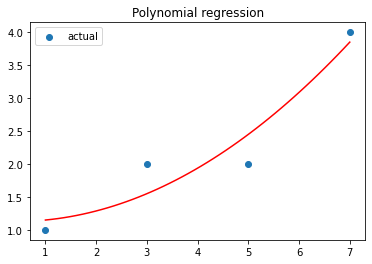

In [27]:
plt.scatter(x, y, label ='actual')
# plt.plot(x, y_hat, color = 'r', label= 'y_hat')
plt.plot(test, y_hat_test, color = 'r')
plt.legend(loc='upper left')
plt.title('Polynomial regression');

In [28]:
x_poly_mat = np.mat(x_poly)
y_mat = np.mat(y)

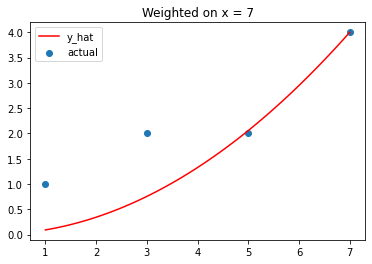

In [30]:
weights = np.mat(np.eye((len(x_poly_mat))))
for j in range(len(x_poly_mat)):
    # calculate difference off last entry
    diff = x_poly_mat[-1] - x_poly_mat[j]
    weights[j, j] = np.exp(np.power(diff @ diff.T, 2) / (-2 * 10**2))
    
W = np.linalg.pinv(x_poly_mat.T @ (weights @ x_poly_mat)) @ (x_poly_mat.T @ weights @ y_mat.T)
y_hat = np.asarray(x_poly_mat @ W).reshape(-1)
y_hat_test = np.asarray(_test_poly @ W).reshape(-1)
# plt.plot(x, y_hat, color = 'r')
plt.plot(test, y_hat_test, color = 'r', label = 'y_hat')
plt.scatter(x, y, label = 'actual')
plt.legend(loc='upper left')
plt.title('Weighted on x = 7');